In [2]:
# import dependencies
import psycopg2
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from config import rds_password

In [3]:
# connect to RDS server to pull bank data
# ENDPOINT="database-1.czh7cscocv0o.us-east-2.rds.amazonaws.com"
# PORT="5432"
# USER="postgres"
# REGION="us-east-2c"
# DBNAME="postgres"


# try:
#     conn = psycopg2.connect(host=ENDPOINT, port=PORT, database=DBNAME, user=USER, password=rds_password, sslrootcert="SSLCERTIFICATE")
#     cur = conn.cursor()
#     cur.execute("SELECT * FROM bank_data")
#     query_results = cur.fetchall()
#     columns = ['index','age','job','marital','education','credit_default','balance','housing_loan','personal_loan','contact','duration_sec','campaign','pdays','previous','poutcome','subscription','date','weekday']
#     bank_df= pd.DataFrame(query_results, columns=columns)
# except Exception as e:
#     print("Database connection failed due to {}".format(e))

In [4]:
# make dataframe from csv
bank_df = pd.read_csv("bank-full_2.csv")
bank_df.head()

,Unnamed: 0,index,age,job,marital,education,credit_default,balance,housing_loan,personal_loan,contact,duration_sec,campaign,pdays,previous,poutcome,subscription,date,weekday
0,0,0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no,2008-05-05,Monday
1,1,1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no,2008-05-05,Monday
2,2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no,2008-05-05,Monday
3,3,3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no,2008-05-05,Monday
4,4,4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no,2008-05-05,Monday


In [5]:
bank_df

,Unnamed: 0,index,age,job,marital,education,credit_default,balance,housing_loan,personal_loan,contact,duration_sec,campaign,pdays,previous,poutcome,subscription,date,weekday
0,0,0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no,2008-05-05,Monday
1,1,1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no,2008-05-05,Monday
2,2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no,2008-05-05,Monday
3,3,3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no,2008-05-05,Monday
4,4,4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no,2008-05-05,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,45206,45206,51,technician,married,tertiary,no,825,no,no,cellular,977,3,-1,0,unknown,yes,2010-11-17,Wednesday
45207,45207,45207,71,retired,divorced,primary,no,1729,no,no,cellular,456,2,-1,0,unknown,yes,2010-11-17,Wednesday
45208,45208,45208,72,retired,married,secondary,no,5715,no,no,cellular,1127,5,184,3,success,yes,2010-11-17,Wednesday
45209,45209,45209,57,blue-collar,married,secondary,no,668,no,no,telephone,508,4,-1,0,unknown,no,2010-11-17,Wednesday


In [6]:
bank_df.isnull().values.any()

False

In [7]:
print(f"Duplicate entries: {bank_df.duplicated().sum()}")

Duplicate entries: 0


In [8]:
bank_df.drop('index',axis=1, inplace=True)

In [9]:
bank_list_binary = ['credit_default','housing_loan','personal_loan','subscription']

In [10]:
# changing data type of binary choices from object to bool
for x in bank_list_binary:
    bank_df[x]=bank_df[x]=="yes"

In [11]:
# change date to datetime format
bank_df['date']=pd.to_datetime(bank_df['date'])

# create data
dates = bank_df['date']

# calculate unix datetime
bank_df['date']=(dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [12]:
bank_list=[]
bank_list=list(bank_df.select_dtypes(include=['object','category']).columns)

In [13]:
# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_df = pd.DataFrame(enc.fit_transform(bank_df[bank_list]))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(bank_list)
encode_df.head()

c:\Users\rab_b\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Merge the two DataFrames together and drop the columns
bank_df=bank_df.merge(encode_df,left_index=True,right_index=True).drop(bank_list,1)

C:\Users\rab_b\AppData\Local\Temp\ipykernel_3888\765185460.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  bank_df=bank_df.merge(encode_df,left_index=True,right_index=True).drop(bank_list,1)


In [15]:
bank_df

,Unnamed: 0,age,credit_default,balance,housing_loan,personal_loan,duration_sec,campaign,pdays,previous,...,poutcome_other,poutcome_success,poutcome_unknown,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0,58,False,2143,True,False,261,1,-1,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,44,False,29,True,False,151,1,-1,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,33,False,2,True,True,76,1,-1,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,47,False,1506,True,False,92,1,-1,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,33,False,1,False,False,198,1,-1,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,45206,51,False,825,False,False,977,3,-1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45207,45207,71,False,1729,False,False,456,2,-1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45208,45208,72,False,5715,False,False,1127,5,184,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45209,45209,57,False,668,False,False,508,4,-1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
bank_df.drop('Unnamed: 0',axis=1, inplace=True)

In [17]:
# set up data x and y
y = bank_df.subscription
X = bank_df.drop(columns="subscription")

In [18]:
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [19]:
# Create a random forest classifier.

for x in np.arange(5,101,5):
    rf_model = RandomForestClassifier(n_estimators=x, random_state=1)

    # Fitting the model
    rf_model = rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred_test = rf_model.predict(X_test)
    y_pred_train = rf_model.predict(X_train)
    prec=precision_score(y_test, y_pred_test)
    print(f" estimator: {x}, precision {prec}") 


 estimator: 5, precision 0.5652951699463328
 estimator: 10, precision 0.6251526251526252
 estimator: 15, precision 0.6338912133891214
 estimator: 20, precision 0.6550060313630881
 estimator: 25, precision 0.6494066882416397
 estimator: 30, precision 0.6436781609195402
 estimator: 35, precision 0.6299126637554585
 estimator: 40, precision 0.6416382252559727
 estimator: 45, precision 0.6447368421052632
 estimator: 50, precision 0.648
 estimator: 55, precision 0.6444444444444445
 estimator: 60, precision 0.6551326412918108
 estimator: 65, precision 0.6465997770345596
 estimator: 70, precision 0.6459054209919262
 estimator: 75, precision 0.6401766004415012
 estimator: 80, precision 0.643348623853211
 estimator: 85, precision 0.6430180180180181
 estimator: 90, precision 0.6516203703703703
 estimator: 95, precision 0.6567505720823799
 estimator: 100, precision 0.6523754345307068


In [20]:
# Create a random forest classifier.

for x in np.arange(15,36):
    rf_model = RandomForestClassifier(n_estimators=x, random_state=1)

    # Fitting the model
    rf_model = rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred_test = rf_model.predict(X_test)
    y_pred_train = rf_model.predict(X_train)
    prec=precision_score(y_test, y_pred_test)
    print(f" estimator: {x}, precision {prec}") 

 estimator: 15, precision 0.6338912133891214
 estimator: 16, precision 0.6411483253588517
 estimator: 17, precision 0.6277836691410392
 estimator: 18, precision 0.6431980906921241
 estimator: 19, precision 0.6349206349206349
 estimator: 20, precision 0.6550060313630881
 estimator: 21, precision 0.6377118644067796
 estimator: 22, precision 0.6485849056603774
 estimator: 23, precision 0.6428571428571429
 estimator: 24, precision 0.6536643026004728
 estimator: 25, precision 0.6494066882416397
 estimator: 26, precision 0.653755868544601
 estimator: 27, precision 0.6433941997851772
 estimator: 28, precision 0.6406067677946324
 estimator: 29, precision 0.6353944562899787
 estimator: 30, precision 0.6436781609195402
 estimator: 31, precision 0.6333687566418703
 estimator: 32, precision 0.6412300683371298
 estimator: 33, precision 0.630965005302227
 estimator: 34, precision 0.6370875995449374
 estimator: 35, precision 0.6299126637554585


In [24]:
rf_model = RandomForestClassifier(n_estimators=20, random_state=1)

# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred_test = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

conf_df= pd.DataFrame(confusion_matrix(y_test, y_pred_test), columns =['Pred_Neg','Pred_Pos'] , index=['Actual_Neg', 'Actual_Pos'] )
print(classification_report(y_test, y_pred_test))

print('Training set metrics:')
print('Accuracy:', accuracy_score(y_train, y_pred_train))
print('Precision:', precision_score(y_train, y_pred_train))
print('Recall:', recall_score(y_train, y_pred_train))

print('Test set metrics:')
print('Accuracy:', accuracy_score(y_test, y_pred_test)) 
print('Precision:', precision_score(y_test, y_pred_test)) 
print('Recall:', recall_score(y_test, y_pred_test)) 
conf_df

              precision    recall  f1-score   support

       False       0.93      0.97      0.95      9998
        True       0.66      0.42      0.51      1305

    accuracy                           0.91     11303
   macro avg       0.79      0.69      0.73     11303
weighted avg       0.90      0.91      0.90     11303

Training set metrics:
Accuracy: 0.9978471157249027
Precision: 0.9997444416049067
Recall: 0.9819277108433735
Test set metrics:
Accuracy: 0.9072812527647527
Precision: 0.6550060313630881
Recall: 0.4160919540229885


,Pred_Neg,Pred_Pos
Actual_Neg,9712,286
Actual_Pos,762,543


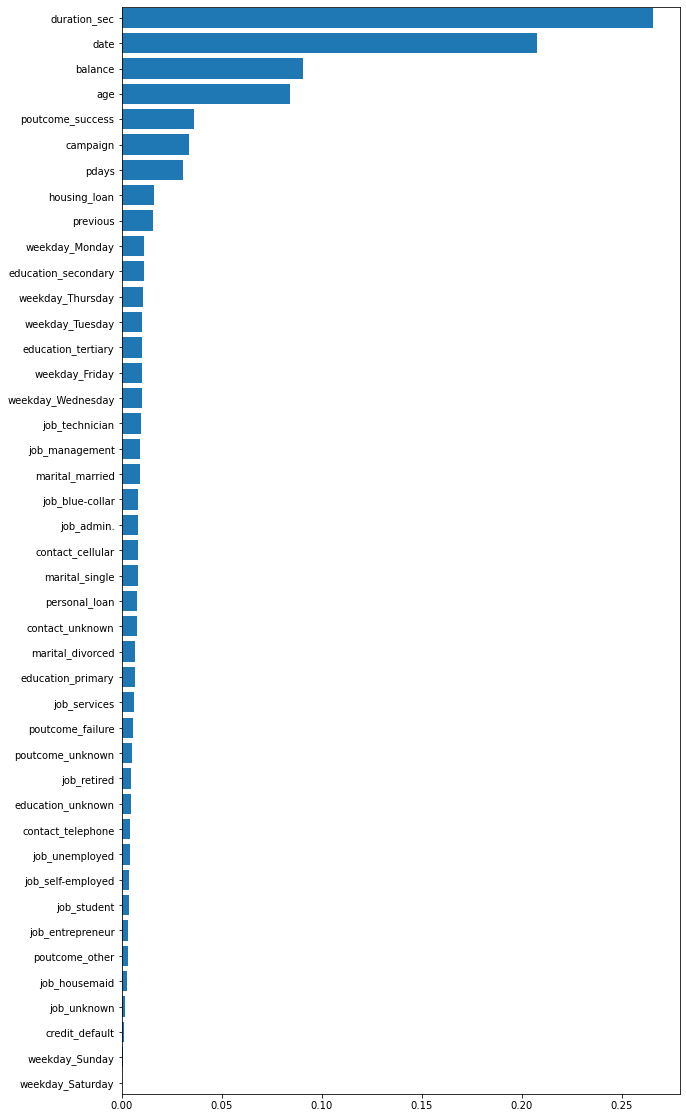

In [25]:
features = rf_model.feature_importances_
features = sorted(zip(X.columns, rf_model.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(10,20)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [26]:
conf_df.to_csv('confusion_matrix.csv')